In [1]:
#from config import manifesto_key
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../src/')
from get_cap_dutch import Get_Cap_Data
from traditional_sml import *

sns.set_theme(style="ticks")
plt.figure(figsize=(20,4))


Train classifiers and make
in-sample and out-of-sample predictions
This code will train traditional sml classifiers, perform resampling to deal with
unbalanced data, and make in-sample and out-of-sample predictions.



<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

## In sample and out of sample prediction of topics that overlap in CAP and CMP

This notebook trains classifiers on topics that overlap in the codebook of [CAP](https://www.comparativeagendas.net/pages/master-codebook) and [CMP](https://manifesto-project.wzb.eu/down/data/2020a/codebooks/codebook_MPDataset_MPDS2020a.pdf) respectively. 
We have selected topics for which coding instructions largely overlap. 

* More specifically, for **CMP**, the following codes were selected:

```python
{'environment': '501',
 'culture': '502',
 'civil_rights': '201',
 'education': ['506', '507'],
 'immigration': ['601', '602']}
```

* For, **CAP**, we have selected the following codes:

```python
{'environment': 7.0,
 'civil_rights': 2.0,
 'culture': 23.0,
 'education': 6.0,
 'immigration': 9.0}
```

Data used in this notebook:

- **CMP**: 
    - country: Netherlands
    - temporal coverage: 2002 - 2017
    - granularity: once per election.
    - more information [here](https://github.com/annekroon/opted2020-linkage/blob/main/reading-datafiles.ipynb)


- **CAP**: 
    - 3 annotated Dutch datafiles, see [here](../src/cap_dutch_files.json)




### Get CAP data

In [20]:
a = Get_Cap_Data('../data/raw-fish/CAP/NL/','../src/cap_topic_codes.json', '../src/cap_dutch_files.json',)
cap = a.get_cap_files()
cap = cap[cap.text.notnull()]

print(f"The cap data contains {len(cap)} observations in total.")
print("observations per class:")

for t in ['environment', 'culture', 'civil_rights', 'education', 'immigration']:
    print(f"{t} : {len(cap[cap[t] == 1])}")

The cap data contains 7745 observations in total.
observations per class:
environment : 252
culture : 50
civil_rights : 185
education : 544
immigration : 341


### Get CMP data

In [22]:
# read CMP data
def get_cmp_data(path_to_file, cmp_codes):
    df = pd.read_csv(path_to_file)
    df = df[['text', 'cmp_code']].dropna()
    
    for k, v in cmp_codes.items():
        if type(v) is list:
            df[k] = np.where((df['cmp_code'] == v[0] ) | (df['cmp_code'] ==v[1] ), 1, 0)
        else:
            df[k] = np.where(df['cmp_code'] == v, 1, 0)
    return df


with open('../src/cmp_topic_codes.json') as json_file: 
    cmp_codes = json.load(json_file)
    
cmp = get_cmp_data(path_to_file='../data/raw-fish/CMP/MPDS2020b_Netherlands.csv', cmp_codes = cmp_codes)

print(f"The cmp data contains {len(cmp)} observations in total.")
print("observations per class:")

for t in ['environment', 'culture', 'civil_rights', 'education', 'immigration']:
    print(f"{t} : {len(cmp[cmp[t] == 1])}")

The cmp data contains 97149 observations in total.
observations per class:
environment : 7387
culture : 1935
civil_rights : 2633
education : 5075
immigration : 815


In [4]:
def run_classifiers(datafile1, datafile2):
    
    a = Classifiers(datafile1, datafile2)
    
    dfs_in_sample = []
    dfs_out_sample = []

    for t in ['environment', 'culture', 'civil_rights', 'education', 'immigration']:
        
        df_insample, df_outsample = a.get_classification_results(t)

        df_in_sample = get_cleaned_data(df_insample)
        df_in_sample['sample'] = 'a. In sample prediction'
        df_in_sample['topic'] = t
        dfs_in_sample.append(df_in_sample)

        df_out_sample = get_cleaned_data(df_outsample)
        df_out_sample['sample'] = 'b. Out of sample prediction'
        df_out_sample['topic'] = t
        dfs_out_sample.append(df_out_sample)

    in_sample = pd.concat(dfs_in_sample)
    out_sample = pd.concat(dfs_out_sample)
    
    return in_sample, out_sample

In [5]:
def get_data_in_right_shape(in_sample, out_sample):
    
    in_sample = in_sample[in_sample['metrics'] == 'f1-score' ] # select on f1-score for now
    
    best_of_insample = in_sample.sort_values(['macro avg'],ascending=False).groupby(['topic']).head(5)
    out_sample_selection = out_sample[['unique_', 'topic', 'classifier', 'vectorizer', 'accuracy', 'metrics', 'macro avg', 'weighted avg', '0', '1']]
    out_sample_selection.rename(columns={'0': '0_out', '1': '1_out','accuracy': 'accuracy_out', 'macro avg' :'macro avg_out', 'weighted avg': 'weighted avg_out'}, inplace=True)
    merged = pd.merge(best_of_insample, out_sample_selection, on=['unique_', 'topic', 'classifier', 'vectorizer', 'metrics'], how='inner')
    
    return merged
    
def melt_df(merged):
    
    merged['id'] = merged.index
    
    melted = pd.melt(merged, id_vars=['id', 'unique_', 'classifier', 'vectorizer', 'metrics', 'topic'], value_vars=['macro avg', 'macro avg_out'],
        var_name='sample_metrics', value_name='f1 - macro average')

    melted['sample'] = np.where(melted['sample_metrics']== 'macro avg', 'In sample prediction', 'Out of sample prediction')
    return melted

# 1. CMP --> CAP

predicting CAP data with CMP training data 

In [6]:
in_sample, out_sample = run_classifiers(cmp, cap)
merged = get_data_in_right_shape(in_sample, out_sample)
melted = melt_df(merged)

0it [00:00, ?it/s]

starting classification of the topic ... environment....
majortopic:environment
Naive Bayes score: 0.830003016240023
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8186120018323408
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators


/Users/anne/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression score: 0.8208750451623904
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.6977353017792167
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:21, 21.70s/it]

Naive Bayes score: 0.8272400501824064
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8280822965788246
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators


/Users/anne/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression score: 0.8267176593689927
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.6908037085617551
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:38, 19.48s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... culture....
majortopic:culture
Naive Bayes score: 0.8330298150294237
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8242847127165893
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators


/Users/anne/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression score: 0.8204107386986765
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7756644138768217
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:07,  7.26s/it]

Naive Bayes score: 0.8238188646907993
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8410255639549737
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.8384988657362198
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7022124164981309
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:13,  6.94s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... civil_rights....
majortopic:civil_rights
Naive Bayes score: 0.7382123293548111
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.7286175740836103
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.7576978728583212
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.6507848406672916
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:09,  9.44s/it]

Naive Bayes score: 0.7342835534037956
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.7684876113109578
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.7523699103525318
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.642848023560423
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:17,  8.97s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... education....
majortopic:education
Naive Bayes score: 0.8506719144773881
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8497139795976079
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.8562657015116032
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.7652332001492144
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:13, 13.57s/it]

Naive Bayes score: 0.8319249969560453
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8585572259241268
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators


/Users/anne/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression score: 0.853684320116604
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7290586176431626
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:26, 13.46s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... immigration....
majortopic:immigration
Naive Bayes score: 0.7358612866634258
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.7484567901234568
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.7453963773229828
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.578448275862069
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:06,  6.35s/it]

Naive Bayes score: 0.7482913437616174
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.759641560798548
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.7653787878787879
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.6562792877225867
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:12,  6.27s/it]

..........loaded the data frame........
..........loaded the data frame........



/Users/anne/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


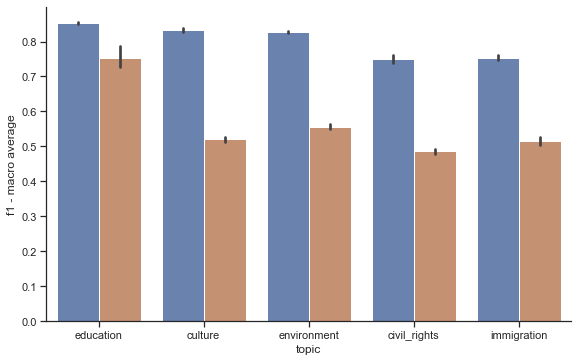

In [7]:
g = sns.catplot(x="topic", y="f1 - macro average", hue="sample", kind='bar', 
                 aspect=1.6,
                 saturation=.5,
                 palette="muted",
                 legend=False,
                 data=melted)

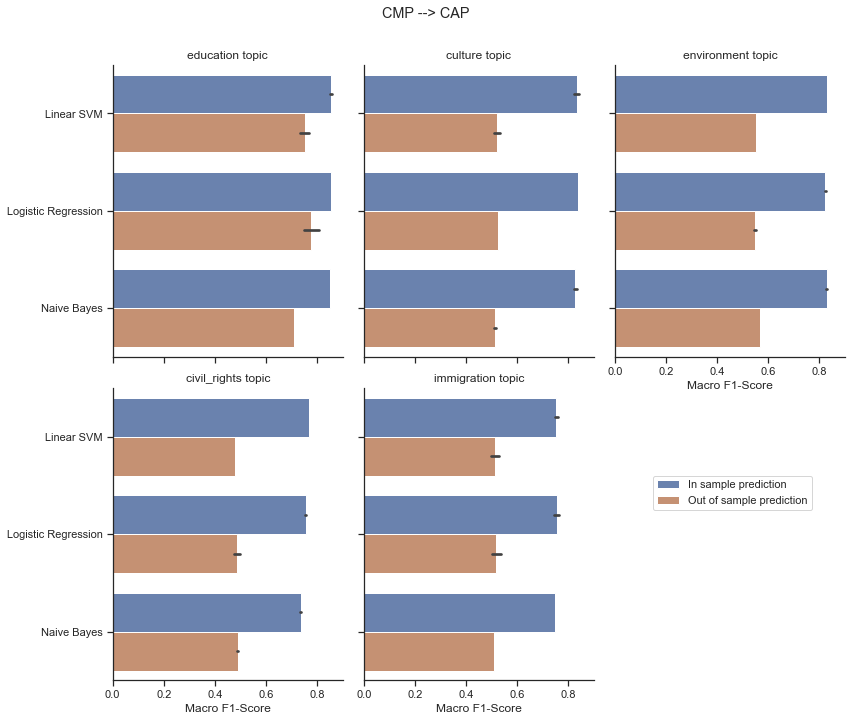

In [10]:
g = sns.catplot(y="classifier", x="f1 - macro average", hue="sample", col="topic", kind='bar', 
                 col_wrap=3,
                 aspect=.8,
                 saturation=.5,
                 palette="muted",
                 legend=False,
                 data=melted)

(g.set_axis_labels("Macro F1-Score", "")
  .set_titles("{col_name} {col_var}"))  

plt.legend(bbox_to_anchor=(1.6, 0.7), loc=9, borderaxespad=0.)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('CMP --> CAP')

plt.show()

# 1. CAP --> CMP

predicting CMP data with CAP training data

In [11]:
in_sample, out_sample = run_classifiers(cap, cmp)
merged = get_data_in_right_shape(in_sample, out_sample)
melted = melt_df(merged)

0it [00:00, ?it/s]

starting classification of the topic ... environment....
majortopic:environment
Naive Bayes score: 0.8216248037676609
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))]) are the best estimators
Linear SVM score: 0.7425490196078433
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.01))]) are the best estimators
Logistic Regression score: 0.7423469387755103
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.6806324110671937
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:13, 13.83s/it]

Naive Bayes score: 0.831087063453025
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.821764705882353
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.8415686274509804
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7423469387755102
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:27, 13.69s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... culture....
majortopic:culture
Naive Bayes score: 0.7150997150997151
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))]) are the best estimators
Linear SVM score: 0.6875
Pipeline(steps=[('vect', CountVectorizer()), ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.6419437340153453
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7493734335839599
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:09,  9.19s/it]

Naive Bayes score: 0.7802197802197802
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.7442455242966752
Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.797979797979798
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.7442455242966752
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:18,  9.14s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... civil_rights....
majortopic:civil_rights
Naive Bayes score: 0.6738782051282051
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.6483918128654971
Pipeline(steps=[('vect', CountVectorizer()), ('clf', LinearSVC(C=0.01))]) are the best estimators
Logistic Regression score: 0.6476190476190476
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.4150761519182572
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=1))]) are the best estimators


1it [00:10, 10.78s/it]

Naive Bayes score: 0.6619662363455809
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.6570898980537535
Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.6570898980537535
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.4329501915708812
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:21, 10.59s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... education....
majortopic:education
Naive Bayes score: 0.8699838118769703
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8669472798063769
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators
Logistic Regression score: 0.8577712301378513
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.31622776601683794))]) are the best estimators
Random Forest score: 0.8089966876803077
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:12, 12.63s/it]

Naive Bayes score: 0.8797215856039385
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.88989898989899
Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.8990740740740741
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.6999569892473118
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:24, 12.20s/it]
0it [00:00, ?it/s]

..........loaded the data frame........
..........loaded the data frame........
starting classification of the topic ... immigration....
majortopic:immigration
Naive Bayes score: 0.8655699855699854
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.001))]) are the best estimators
Linear SVM score: 0.7596491228070176
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LinearSVC(C=0.31622776601683794))]) are the best estimators


/Users/anne/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression score: 0.7977030352748155
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.4956492637215528
Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


1it [00:11, 11.12s/it]

Naive Bayes score: 0.8729128014842301
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.01))]) are the best estimators
Linear SVM score: 0.8338844797178129
Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10.0))]) are the best estimators
Logistic Regression score: 0.8582938646632914
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10.0))]) are the best estimators
Random Forest score: 0.5766332339387368
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=2))]) are the best estimators


2it [00:24, 12.28s/it]

..........loaded the data frame........
..........loaded the data frame........



/Users/anne/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


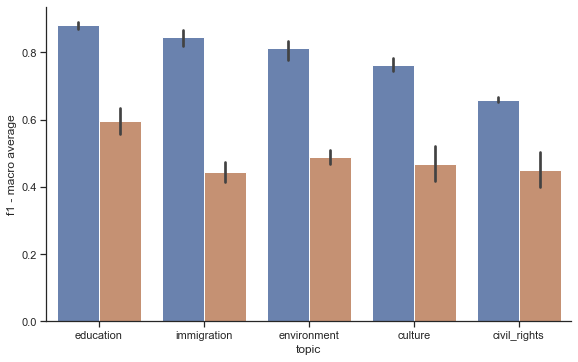

In [27]:
g = sns.catplot(x="topic", y="f1 - macro average", hue="sample", kind='bar', 
                 aspect=1.6,
                 saturation=.5,
                 palette="muted",
                 legend=False,
                 data=melted)

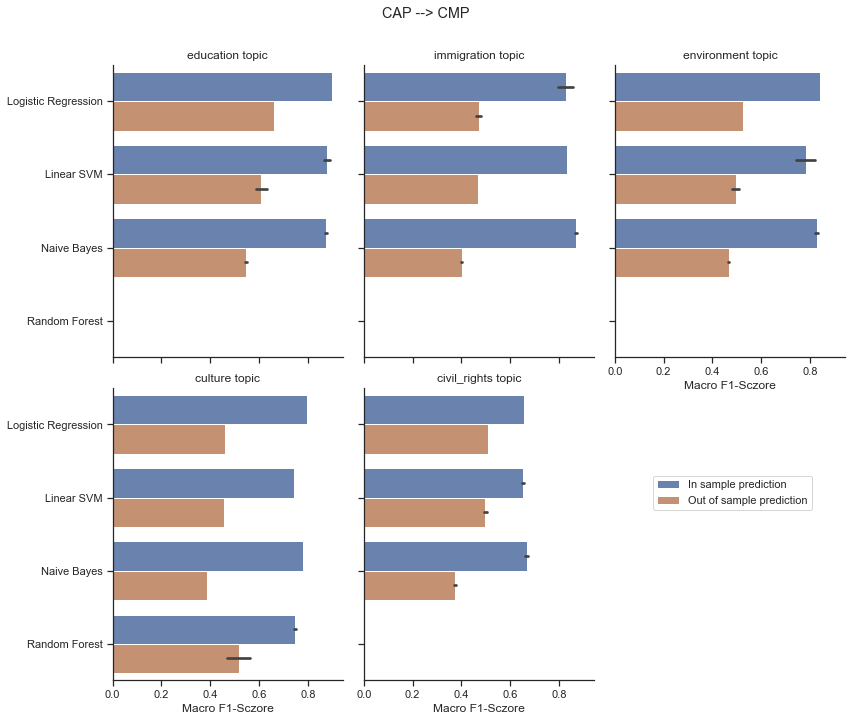

In [28]:
g = sns.catplot(y="classifier", x="f1 - macro average", hue="sample", col="topic", kind='bar', 
                 col_wrap=3,
                 aspect=.8,
                 saturation=.5,
                 palette="muted",
                 legend=False,
                 data=melted)

(g.set_axis_labels("Macro F1-Sczore", "")
  .set_titles("{col_name} {col_var}"))  

plt.legend(bbox_to_anchor=(1.6, 0.7), loc=9, borderaxespad=0.)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('CAP --> CMP')

plt.show()